# Data Science in Economics and Business - Class Project
In this class project, you are supposed to work with experimental data from the paper "The Many Faces of Human Sociality: Uncovering the Distribution and Stability of Social Preferences" by Bruhin, Fehr, and Schunk, published in the *Journal of the European Economic Association* 17(4): 1025-1069, 2019: https://doi.org/10.1093/jeea/jvy018

**IMPORTANT:** <br>
Please enter the matriculation number of all group members here:
1. 2331979


In this class project, you will use the different techniques taught in the course: data handling, data visualization, and machine learning.

First load the necessary packages. <br>
If you want to use additional libraries you can add them to the following cell:

In [ ]:
!pip install imblearn

In [3]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor,
                              GradientBoostingRegressor, RandomForestRegressor)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (silhouette_score, r2_score, mean_absolute_error,
                             mean_squared_error, accuracy_score, precision_score,
                             recall_score, f1_score)
from sklearn.model_selection import (GridSearchCV, train_test_split)
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.ensemble import BalancedRandomForestClassifier

import gdown

sns.set()
warnings.filterwarnings("ignore", category=FutureWarning)

The authors observe human behavior in the so-called dictator game: One player (*dictator*) receives a certain amount of money and can distribute this endowment between herself and another player (*receiver*). The decision of the dictator is implemented, and the receiver has no choice to take and must accept the dictator's decision. <br>
The authors employ a binary version of the dictator game in which the dictator can choose between two alternative allocation options *X* and *Y*. Each dictator in the experiment plays 30 of these dictator games with varying pairs of decision alternatives. <br>
All subjects in the experiment were students from the University of Zurich and the Swiss Federal Institute of Technology Zurich.

# Problem 1 - Data Handling
The basis of your work will be the following two datasets:
- `choices.csv` contains the decisions of the dictators across the 30 variations of the binary dictator game.
    - *sid* is the ID of the subject.
    - *gid* is the ID of the game variation.
    - *order* is the (random) order in which the game appeared in the block of dictator games.
    - *self_x* and *self_y* are the payoffs of the dictator in choice option X and Y, respectively.
    - *other_x* and *other_y* are the payoffs of the receiver in choice option X and Y, respectively.
    - *choice_x* describes the decision of the dictator, with a value of 1 representing the choice of option X, and 0 the choice of option Y.
    - *s_x* and *s_y* are indicators of disadvantageous inequality for the dictator in option X and option Y, respectively. That is, *s_x* equals 1 if the dictator receives lower payoff in option X than the receiver, and 0 if the dictator receive higher payoff in option X than the receiver.
    - *r_x* and *r_y* are indicators of advantageous inequality for the dictator in option X and option Y, respectively. That is, *r_x* equals 1 if the dictator receives higher payoff in option X than the receiver, and 0 if the dictator receive lower payoff in option X than the receiver.
    - Note that *r_x = 1 - s_x* and *r_y = 1 - s_y*
- `subjects.csv` contains the results from the post-experimental questionnaire.
    - *sid* is the ID of the subject.
    - *bf_consciousness, bf_openness, bf_extraversion, bf_agreeableness, bf_neuroticism* are the results from the Big Five measures.
    - *cogabil* is a measure of cognitive ability.
    - *pe_D1_stud_natsci, pe_D1_stud_law, pe_D1_stud_socsci, pe_D1_stud_med* indicate the subject's field of study (natural sciences, law, social sciences, or medicine, respectively).
    - *pe_monthinc* is the subject's monthly income.
    - *pe_age* is the subject's age.
    - *pe_female* equals 1 if the subject is female, and 0 otherwise.

**Load Data**

-> preference data will be explained in Problem 3c but we upload it here for cleaner code

In [6]:
# loading the data from Google Drive so we dont have to upload them each time when using colab

# use the file IDs to download the files

# File IDs
file_id_choices = '1UbaB93FOoLna3J-0TN2Ouhvl3NYtylzk'
file_id_subjects = '1pzclTnqww_h4-ZEnbWD5tbHPvJrR4Tu-'
file_id_preference_data = '1xLBmM-B8aYhV5nVvBSM6jBmCuZl0Mtis'

# Download the files and name them accordingly
gdown.download(f'https://drive.google.com/uc?id={file_id_choices}', 'choices.csv', quiet=False)
gdown.download(f'https://drive.google.com/uc?id={file_id_subjects}', 'subjects.csv', quiet=False)
gdown.download(f'https://drive.google.com/uc?id={file_id_preference_data}', 'preference_data.csv', quiet=False)

choices = pd.read_csv('choices.csv')
subjects = pd.read_csv('subjects.csv')
preference_data = pd.read_csv('preference_data.csv', delimiter=';')

# Display the first few rows of each dataframe to ensure they're loaded correctly
print("Choices DataFrame:")
display(choices.head())

print("\nSubjects DataFrame:")
display(subjects.head())

print("\nPreference Data DataFrame:")
display(preference_data.head())


Downloading...
From: https://drive.google.com/uc?id=1UbaB93FOoLna3J-0TN2Ouhvl3NYtylzk
To: /content/choices.csv
100%|██████████| 316k/316k [00:00<00:00, 95.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pzclTnqww_h4-ZEnbWD5tbHPvJrR4Tu-
To: /content/subjects.csv
100%|██████████| 7.25k/7.25k [00:00<00:00, 9.65MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xLBmM-B8aYhV5nVvBSM6jBmCuZl0Mtis
To: /content/preference_data.csv
100%|██████████| 145k/145k [00:00<00:00, 89.8MB/s]

Choices DataFrame:


,sid,gid,order,self_x,self_y,other_x,other_y,choice_x,s_y,s_x,r_y,r_x
0,102010050706,361,1,940,800,150,510,0,0,0,1,1
1,102010050706,281,2,970,770,490,170,0,0,0,1,1
2,102010050706,391,3,1060,680,330,330,1,0,0,1,1
3,102010050706,271,4,990,750,480,180,1,0,0,1,1
4,102010050706,311,5,930,810,510,150,0,0,0,1,1



Subjects DataFrame:


,sid,bf_consciousness,bf_openness,bf_extraversion,bf_agreeableness,bf_neuroticism,cogabil,pe_D1_stud_natsci,pe_D1_stud_law,pe_D1_stud_socsci,pe_D1_stud_med,pe_monthinc,pe_age,pe_female
0,12010050501,9,17,4,11,-1,3,1,0,0,0,400,21,1
1,12010050502,5,22,4,7,7,7,1,0,0,0,800,21,0
2,12010050603,4,18,4,9,7,3,0,0,1,0,800,23,0
3,12010050704,8,17,1,10,7,9,1,0,0,0,500,22,0
4,12010050705,10,15,-3,12,0,4,0,0,0,1,350,19,1



Preference Data DataFrame:


,TAS,TAS21,ER30001,ER30002,ER32000,ER32006,ER34901,ER34902,ER34903,TA210001,...,TA212323,TA212324,TA212325,TA212328,TA212333,TA212334,TA212335,TA212336,TA212337,TA212346
0,1,1,4,42,1,2,7535,1,10,1,...,1,1,1,0,97,97,97,97,97,3
1,1,1,4,44,2,2,3753,2,30,1,...,1,1,1,3,15,16,11,14,19,3
2,1,1,5,33,1,2,4065,1,10,1,...,3,1,2,0,97,97,97,97,97,6
3,1,1,7,46,2,2,6614,2,20,1,...,5,1,1,0,97,97,97,97,97,5
4,1,1,7,47,2,2,4476,2,20,1,...,2,1,1,0,97,97,97,97,97,4


#### a)
Merge the two datasets into one. <br>
Check whether you have behavioral data (from `choices`) and personal information (from `subjects`) on all subjects. <br>
If not, create an indicator for missing data and list the IDs of the subjects concerned.

In [7]:
# Merge the datasets on 'sid' using an outer join
merged_data = pd.merge(choices, subjects, on='sid', how='outer', indicator=True)

# Create indicators for missing behavioral data and personal information
merged_data['only_choices_data'] = merged_data['_merge'] == 'left_only'
merged_data["only_subject_data"] = merged_data['_merge'] == 'right_only'

# List the IDs of the subjects with missing behavioral data or personal information
missing_behavioral_ids = merged_data.loc[merged_data['only_choices_data'], 'sid'].unique()
missing_personal_ids = merged_data.loc[merged_data['only_subject_data'], 'sid'].unique()

# Display the relevant columns to check the indicators
missing_data_summary = merged_data[['sid', 'only_choices_data', 'only_subject_data']]

print("only_choices_data IDs:", missing_behavioral_ids)
print("only_subject_data Data IDs:", missing_personal_ids)


only_choices_data IDs: [102010050706  62010050706 202010050704 122010050603 172010050501
 212010050704 362010050501  82010050705 162010050502 192010050502
 292010050502 132010050706 152010050706 172010050704]
only_subject_data Data IDs: []


on 14 Subjects we have no personal Information and only the behavioral data

Column merge: left only indicateds that we only have behavioral Information here without personal Data on this ID

In [8]:
# Display the count of each value in the _merge column
merge_value_counts = merged_data['_merge'].value_counts()
print("\nValue counts for _merge column:")
print(merge_value_counts)


Value counts for _merge column:
_merge
both          6240
left_only      546
right_only       0
Name: count, dtype: int64


We are missing Subject Information of 14 Subjects which made in sum 546 choices

#### b)
Try out different representations of the data (long vs. wide etc.).

Wide Format

In [9]:
display(merged_data.head())


,sid,gid,order,self_x,self_y,other_x,other_y,choice_x,s_y,s_x,...,pe_D1_stud_natsci,pe_D1_stud_law,pe_D1_stud_socsci,pe_D1_stud_med,pe_monthinc,pe_age,pe_female,_merge,only_choices_data,only_subject_data
0,102010050706,361,1,940,800,150,510,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,True,False
1,102010050706,281,2,970,770,490,170,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,True,False
2,102010050706,391,3,1060,680,330,330,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,True,False
3,102010050706,271,4,990,750,480,180,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,True,False
4,102010050706,311,5,930,810,510,150,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,True,False


Long Format

In [10]:
merged_data_long = merged_data.melt(id_vars=['sid', 'gid', 'order'],
                                    value_vars=['self_x', 'self_y', 'other_x', 'other_y', 'choice_x', 's_x', 's_y', 'r_x', 'r_y',
                                                'bf_neuroticism', 'cogabil', 'pe_D1_stud_natsci', 'pe_D1_stud_law', 'pe_D1_stud_socsci',
                                                'pe_D1_stud_med', 'pe_monthinc', 'pe_age', 'pe_female', '_merge'],
                                    var_name='variable', value_name='value')

# Display the transformed DataFrame
display(merged_data_long.head())

,sid,gid,order,variable,value
0,102010050706,361,1,self_x,940
1,102010050706,281,2,self_x,970
2,102010050706,391,3,self_x,1060
3,102010050706,271,4,self_x,990
4,102010050706,311,5,self_x,930


Mean Values of their payoffs

In [11]:
pivot_table = merged_data.pivot_table(
    values=['self_x', 'self_y', 'other_x', 'other_y'],
    index=['sid', 'gid'],
    aggfunc='mean'
)
display(pivot_table)

other_x  other_y  self_x  self_y
sid          gid                                  
12010050501  11    1020.0    720.0   450.0   210.0
             21    1030.0    710.0   430.0   230.0
             31    1060.0    680.0   350.0   310.0
             41    1060.0    680.0   370.0   290.0
             51    1050.0    690.0   390.0   270.0
...                   ...      ...     ...     ...
362010050501 351    140.0    520.0   890.0   850.0
             361    150.0    510.0   940.0   800.0
             371    190.0    470.0  1010.0   730.0
             381    270.0    390.0  1050.0   690.0
             391    330.0    330.0  1060.0   680.0

[6786 rows x 4 columns]

# Problem 2 - Data Visualization
#### a)
As a first type of visualization, focus on the choices and the decision scenarios. <br>
That is, use the payoffs and indicators of (dis)advantageous inequality. <br>
You can use any kind that you deem useful: histograms, line plots, etc.

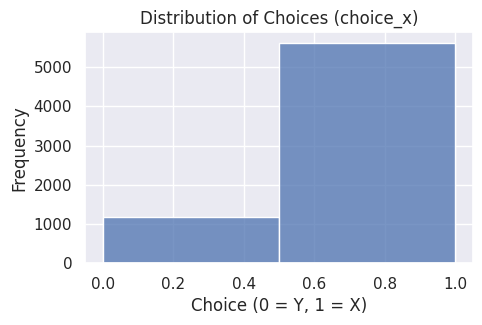

Percentage of choices:
Choice 1: 82.64%
Choice 0: 17.36%


In [12]:
# Calculate percentage distribution of choices
choice_counts = merged_data['choice_x'].value_counts(normalize=True) * 100

# Plot 1: Histogram of Choices
plt.figure(figsize=(5, 3))
sns.histplot(merged_data['choice_x'], bins=2, kde=False)
plt.title('Distribution of Choices (choice_x)')
plt.xlabel('Choice (0 = Y, 1 = X)')
plt.ylabel('Frequency')
plt.show()

# Print percentage distribution of choices
print("Percentage of choices:")
for choice, percentage in choice_counts.items():
    print(f"Choice {choice}: {percentage:.2f}%")

The results show that the majority of subjects (82.64%) chose option X (choice_x = 1), while a smaller proportion (17.36%) chose option Y (choice_x = 0). This indicates a strong preference for option X among the participants in the dataset.

This is important later when we want to make predictions

**Payoffs**

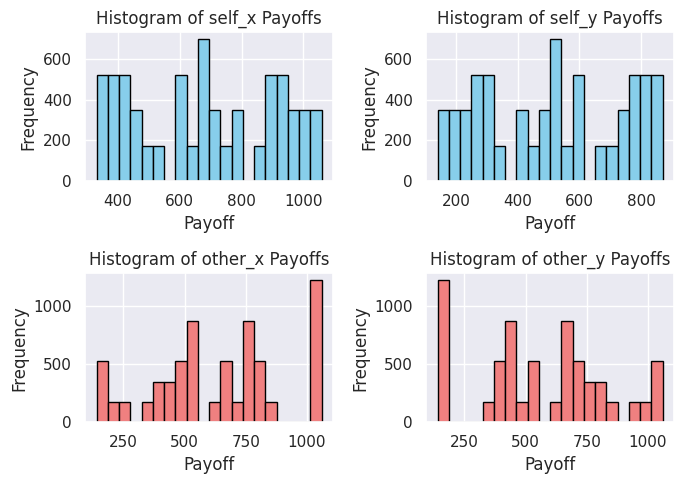

In [14]:
# Histogram of payoffs for self and other
fig, axes = plt.subplots(2, 2, figsize=(7, 5))

# Histogram for self_x and self_y
axes[0, 0].hist(merged_data['self_x'].dropna(), bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Histogram of self_x Payoffs')
axes[0, 0].set_xlabel('Payoff')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(merged_data['self_y'].dropna(), bins=20, color='skyblue', edgecolor='black')
axes[0, 1].set_title('Histogram of self_y Payoffs')
axes[0, 1].set_xlabel('Payoff')
axes[0, 1].set_ylabel('Frequency')

# Histogram for other_x and other_y
axes[1, 0].hist(merged_data['other_x'].dropna(), bins=20, color='lightcoral', edgecolor='black')
axes[1, 0].set_title('Histogram of other_x Payoffs')
axes[1, 0].set_xlabel('Payoff')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(merged_data['other_y'].dropna(), bins=20, color='lightcoral', edgecolor='black')
axes[1, 1].set_title('Histogram of other_y Payoffs')
axes[1, 1].set_xlabel('Payoff')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The histograms reveal that the payoffs for both the dictator and the receiver are spread across a wide range, offering a variety of decision scenarios. The payoffs for the dictator in both options are evenly distributed, showing no preference for specific amounts. Meanwhile, the receiver's payoffs also vary but with some amounts appearing more frequently, indicating certain scenarios are more common. Exspecially the highest Payoff for other_x  the highest is the most frequent, while the lowest payoff for other_y ist the least frequent.

**Inequality Indicators**

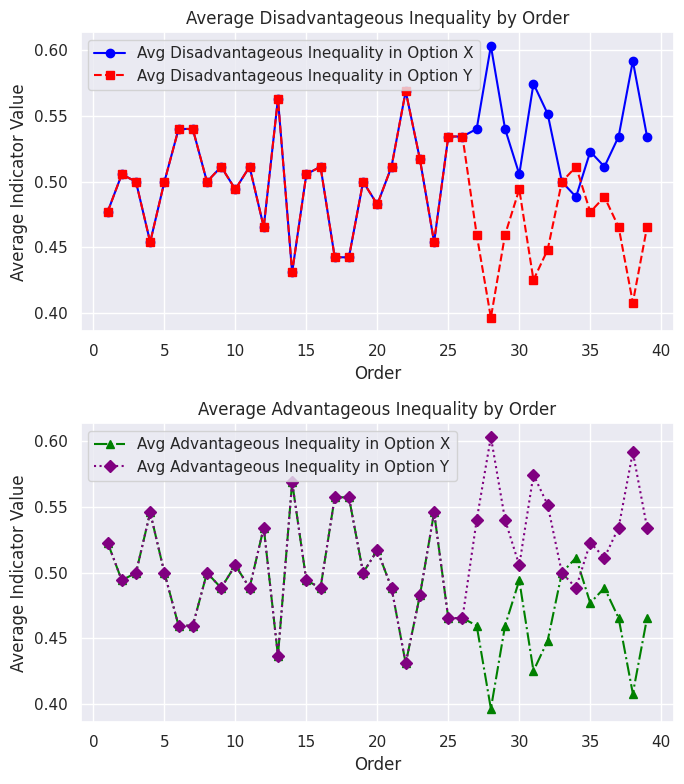

In [15]:
# Aggregating data for visualization
inequality_data = merged_data[['sid', 'gid', 'order', 's_x', 's_y', 'r_x', 'r_y']]
inequality_agg = inequality_data.groupby('order').mean()

# Plotting the average indicators of inequality per order in two separate plots
fig, axes = plt.subplots(2, 1, figsize=(7, 8))

# Plot for Disadvantageous Inequality
axes[0].plot(inequality_agg.index, inequality_agg['s_x'], label='Avg Disadvantageous Inequality in Option X', color='blue', linestyle='-', marker='o')
axes[0].plot(inequality_agg.index, inequality_agg['s_y'], label='Avg Disadvantageous Inequality in Option Y', color='red', linestyle='--', marker='s')
axes[0].set_title('Average Disadvantageous Inequality by Order')
axes[0].set_xlabel('Order')
axes[0].set_ylabel('Average Indicator Value')
axes[0].legend()

# Plot for Advantageous Inequality
axes[1].plot(inequality_agg.index, inequality_agg['r_x'], label='Avg Advantageous Inequality in Option X', color='green', linestyle='-.', marker='^')
axes[1].plot(inequality_agg.index, inequality_agg['r_y'], label='Avg Advantageous Inequality in Option Y', color='purple', linestyle=':', marker='D')
axes[1].set_title('Average Advantageous Inequality by Order')
axes[1].set_xlabel('Order')
axes[1].set_ylabel('Average Indicator Value')
axes[1].legend()

plt.tight_layout()
plt.show()

The inequality plots indicate that the average disadvantageous and advantageous inequalities for the dictator are fairly balanced across different game orders, with values hovering around 0.5. This balance suggests that the game scenarios do not consistently favor the dictator being either better or worse off compared to the receiver. There are slight fluctuations in the averages, showing some variability in the degree of inequality experienced in different game orders

#### b)
Now also include the information on the subjects from the questionnaires in your plots. <br>
You can use any kind that you deem useful: histograms, line plots, etc.

**Subjects Informations**

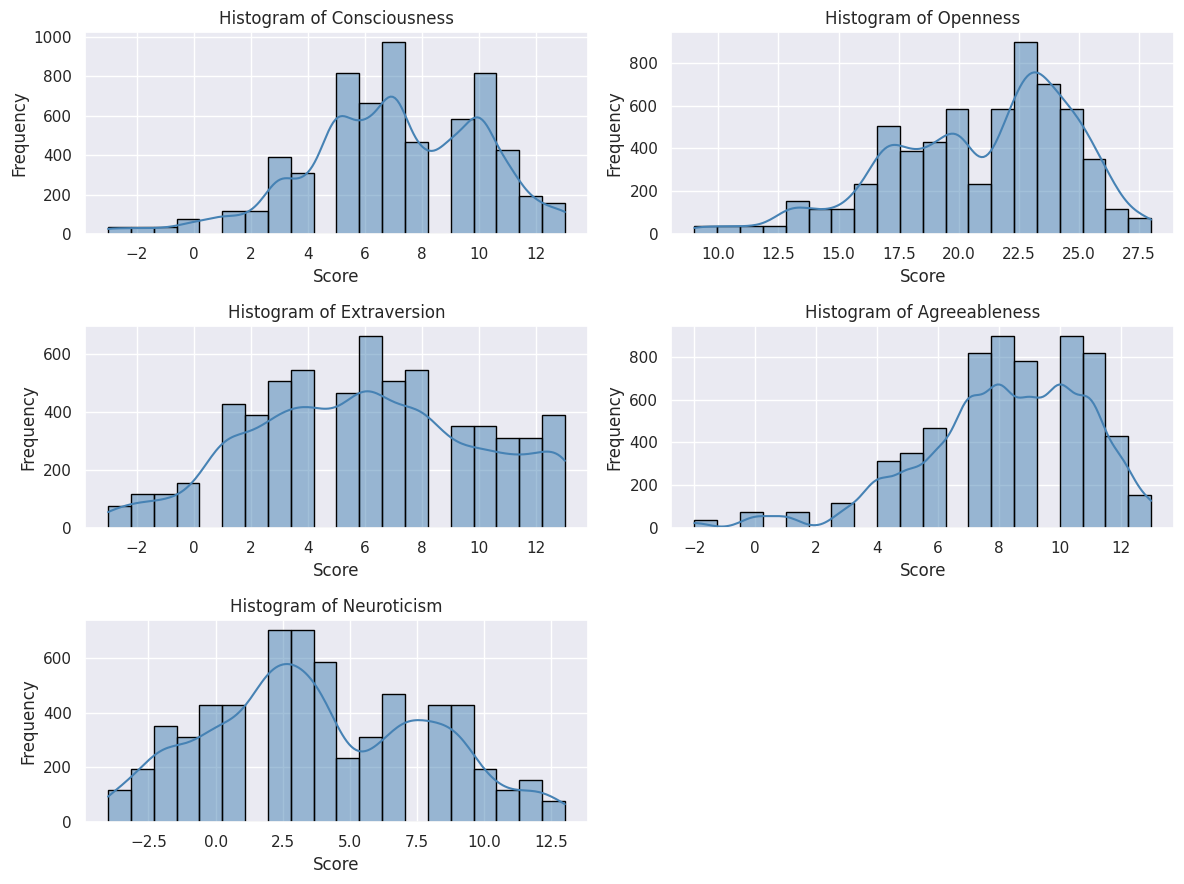

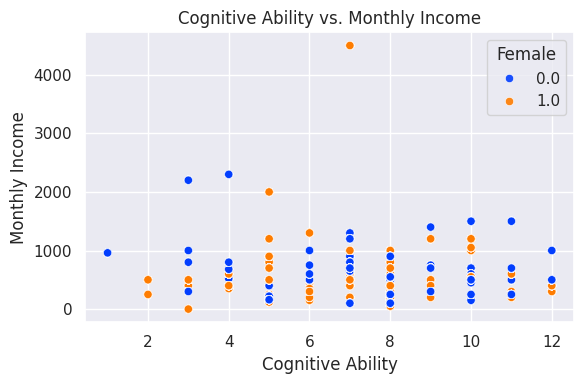

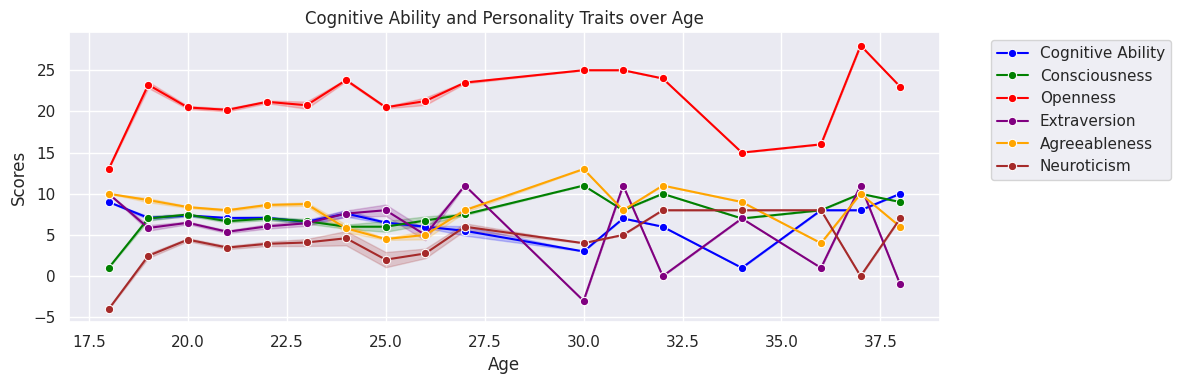

In [16]:

# histograms of Big Five personality traits with merged_data
traits = ['bf_consciousness', 'bf_openness', 'bf_extraversion', 'bf_agreeableness', 'bf_neuroticism']
fig, axes = plt.subplots(3, 2, figsize=(12, 9))

for ax, trait in zip(axes.flatten(), traits):
    sns.histplot(merged_data[trait].dropna(), bins=20, kde=True, ax=ax,
alpha=0.5,
color='steelblue',
edgecolor='black')
    ax.set_title(f'Histogram of {trait.split("_")[1].capitalize()}')
    ax.set_xlabel('Score')
    ax.set_ylabel('Frequency')

# Removing the last empty subplot
fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.show()

# Scatter plot for cognitive ability vs. monthly income, colored by gender
fig, ax = plt.subplots(figsize=(6, 4))
scatter = sns.scatterplot(x='cogabil', y='pe_monthinc', hue='pe_female', palette='bright', data=merged_data.dropna(subset=['cogabil', 'pe_monthinc', 'pe_female']), ax=ax, alpha=0.9)
ax.set_title('Cognitive Ability vs. Monthly Income')
ax.set_xlabel('Cognitive Ability')
ax.set_ylabel('Monthly Income')
scatter.legend(title="Female")

plt.tight_layout()
plt.show()

# line plot for cognitive ability and personality traits over age with legend outside the plot
traits_labels_colors = [
    ('cogabil', 'Cognitive Ability', 'blue'),
    ('bf_consciousness', 'Consciousness', 'green'),
    ('bf_openness', 'Openness', 'red'),
    ('bf_extraversion', 'Extraversion', 'purple'),
    ('bf_agreeableness', 'Agreeableness', 'orange'),
    ('bf_neuroticism', 'Neuroticism', 'brown')
]

fig, ax = plt.subplots(figsize=(12, 4))

for trait, label, color in traits_labels_colors:
    sns.lineplot(x='pe_age', y=trait, data=merged_data.dropna(subset=['pe_age', trait]), label=label, ax=ax, marker='o', color=color)

ax.set_title('Cognitive Ability and Personality Traits over Age')
ax.set_xlabel('Age')
ax.set_ylabel('Scores')

# Move legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


**1. Histograms of Big Five Personality Traits:**

These histograms show the distribution of scores for consciousness, openness, extraversion, agreeableness, and neuroticism. The varied distributions indicate diversity in the sample's personality traits, with peaks suggesting common score ranges. Also the negatives values should be scaled correctly later.

**2. Scatter Plot of Cognitive Ability vs. Monthly Income, Colored by Gender:**

This plot shows the relationship between cognitive ability and monthly income, with colors indicating gender. The spread suggests no strong correlation between cognitive ability and income. Both genders are evenly distributed across the range, indicating no significant income disparity based on gender.

**3. Line Plot of Cognitive Ability and Personality Traits over Age:**

This plot shows how cognitive ability and personality traits change with age. Cognitive ability remains relatively stable, while traits like openness and extraversion vary more in younger ages. Other traits, such as consciousness, agreeableness, and neuroticism, show minor variations across ages.




# Problem 3 - Supervised Machine Learning
#### a)
Try to predict the choices of subjects using the information provided. <br>
Report the performance measures for different predictor variables.

**Clean and handle missing data**

--> here we just gonna drop the columns with the missing subject data since task b) is already about imputing the values.

In [17]:
# Filter out rows where `only_choices_data` is True
merged_data_filtered = merged_data[~merged_data['only_choices_data']]

#drop only choices/subject labels from the table:
merged_data_filtered = merged_data_filtered.drop(columns=['only_choices_data', 'only_subject_data', "_merge"])

# Drop rows with any missing values
merged_data_cleaned = merged_data_filtered.dropna()
display (merged_data_cleaned.head())

,sid,gid,order,self_x,self_y,other_x,other_y,choice_x,s_y,s_x,...,bf_agreeableness,bf_neuroticism,cogabil,pe_D1_stud_natsci,pe_D1_stud_law,pe_D1_stud_socsci,pe_D1_stud_med,pe_monthinc,pe_age,pe_female
39,112010050603,11,1,450,210,1020,720,1,1,1,...,4.0,1.0,3.0,0.0,0.0,1.0,0.0,2200.0,21.0,0.0
40,112010050603,61,2,410,250,1050,690,1,1,1,...,4.0,1.0,3.0,0.0,0.0,1.0,0.0,2200.0,21.0,0.0
41,112010050603,391,3,1060,680,330,330,1,0,0,...,4.0,1.0,3.0,0.0,0.0,1.0,0.0,2200.0,21.0,0.0
42,112010050603,111,4,470,190,730,1010,1,1,1,...,4.0,1.0,3.0,0.0,0.0,1.0,0.0,2200.0,21.0,0.0
43,112010050603,21,5,430,230,1030,710,1,1,1,...,4.0,1.0,3.0,0.0,0.0,1.0,0.0,2200.0,21.0,0.0


Since the Datasets are pretty clean and had no NaN Values or missing data we can simply just drop the lines were we didnt had the personal Information and dont need Imputers etc.

### Model Performance Analysis

We evaluate various machine learning models using different predictor sets to assess their performance. The predictor sets include:

- **Personality Traits**: Personal characteristics
- **Cognitive Ability and Income**: Financial and cognitive metrics
- **Demographics**: Basic demographic details
- **Fields of Study**: Academic backgrounds
- **All Features**: Comprehensive feature set

 We used `class_weight="balanced"` to mitigate class imbalances in the dataset, ensuring that models can better handle minority classes and produce more accurate results. Reason is as we saw in 2 a) that our target variable is disributed 83% to 17% which would be  bias the models if they dont use the **balanced class weights.**


In [18]:

# Suppress FutureWarnings related to imbalanced-learn
warnings.filterwarnings('ignore', category=FutureWarning, module='imblearn')

# Load your dataset (update the path as necessary)
# merged_data_cleaned = pd.read_csv('path_to_your_data.csv')  # Uncomment and update path if needed

# Define different sets of predictor variables
predictor_sets = {
    'Personality Traits': [
        'bf_consciousness', 'bf_openness', 'bf_extraversion', 'bf_agreeableness', 'bf_neuroticism'
    ],
    'Cognitive Ability and Income': ['cogabil', 'pe_monthinc'],
    'Demographics': ['pe_age', 'pe_female'],
    'Fields of Study': ['pe_D1_stud_natsci', 'pe_D1_stud_law', 'pe_D1_stud_socsci', 'pe_D1_stud_med'],
    'All Features': [
        'bf_consciousness', 'bf_openness', 'bf_extraversion', 'bf_agreeableness',
        'bf_neuroticism', 'cogabil', 'pe_monthinc', 'pe_age', 'pe_female',
        'pe_D1_stud_natsci', 'pe_D1_stud_law', 'pe_D1_stud_socsci', 'pe_D1_stud_med',
        'sid', 'gid', 'order', 'self_x', 'self_y', 'other_x', 'other_y', 's_y', 's_x'
    ]
}

# Target variable
target_var = 'choice_x'

# Define models and their reduced hyperparameter grids
model_param_grids = {
    'Logistic Regression': {
        'model': LogisticRegression(class_weight='balanced', max_iter=1000),
        'params': {
            'C': [0.1, 1],
            'solver': ['liblinear']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(class_weight='balanced'),
        'params': {
            'criterion': ['gini'],
            'max_depth': [None, 10]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(class_weight='balanced'),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [None, 10],
            'criterion': ['gini']
        }
    },
    'SVM': {
        'model': SVC(class_weight='balanced'),
        'params': {
            'C': [0.1, 1],
            'kernel': ['linear'],
            'gamma': ['scale']
        }
    },
    'Balanced Random Forest': {
        'model': BalancedRandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [None, 10],
            'criterion': ['gini']
        }
    }
}

# Function to prepare data for each evaluation
def prepare_data(data, predictors, target):
    # Drop rows with missing values in predictor or target variables
    data = data.dropna(subset=predictors + [target])

    # Split data into features (X) and target (y)
    X = data[predictors]
    y = data[target]

    # Identify numerical predictors
    numerical_predictors = [p for p in predictors if X[p].dtype in ['int64', 'float64']]

    # Normalize numerical features (standardization)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X[numerical_predictors])

    return X_scaled, y

# Function to perform hyperparameter tuning and evaluate model performance
def evaluate_model_performance_with_tuning(models_param_grids, predictors, target):
    X, y = prepare_data(merged_data_cleaned, predictors, target)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    results = []
    for model_name, params in models_param_grids.items():
        model = params['model']
        param_grid = params['params']

        # Perform GridSearchCV to find the best hyperparameters
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Get the best model from grid search
        best_model = grid_search.best_estimator_

        # Predict using the test set
        y_pred = best_model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        results.append({
            'Model': model_name,
            'Predictor Set': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Best Params': grid_search.best_params_
        })

    return results

# Evaluate model performance for each set of predictors with hyperparameter tuning
all_results = []
for name, predictors in predictor_sets.items():
    results = evaluate_model_performance_with_tuning(model_param_grids, predictors, target_var)
    all_results.extend(results)

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(all_results)

# Print the DataFrame
display(results_df)


,Model,Predictor Set,Accuracy,Precision,Recall,F1 Score,Best Params
0,Logistic Regression,Personality Traits,0.568910,0.868272,0.579395,0.695011,"{'C': 0.1, 'solver': 'liblinear'}"
1,Decision Tree,Personality Traits,0.512821,0.882653,0.490548,0.630620,"{'criterion': 'gini', 'max_depth': 10}"
2,Random Forest,Personality Traits,0.573718,0.873580,0.581285,0.698070,"{'criterion': 'gini', 'max_depth': 10, 'n_esti..."
3,SVM,Personality Traits,0.632212,0.867485,0.668242,0.754939,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}"
4,Balanced Random Forest,Personality Traits,0.509615,0.880546,0.487713,0.627737,"{'criterion': 'gini', 'max_depth': 10, 'n_esti..."
5,Logistic Regression,Cognitive Ability and Income,0.521635,0.848714,0.530246,0.652705,"{'C': 0.1, 'solver': 'liblinear'}"
6,Decision Tree,Cognitive Ability and Income,0.542468,0.872894,0.538752,0.666277,"{'criterion': 'gini', 'max_depth': None}"
7,Random Forest,Cognitive Ability and Income,0.537660,0.867176,0.536862,0.663164,"{'criterion': 'gini', 'max_depth': 10, 'n_esti..."
8,SVM,Cognitive Ability and Income,0.503205,0.857843,0.496219,0.628743,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}"
9,Balanced Random Forest,Cognitive Ability and Income,0.544071,0.872146,0.541588,0.668222,"{'criterion': 'gini', 'max_depth': None, 'n_es..."


<ipython-input-19-0bf411317a46>:7: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.barplot(data=results_df, x='Predictor Set', y='Accuracy', hue='Model', palette=palette, ci=None, edgecolor='w')


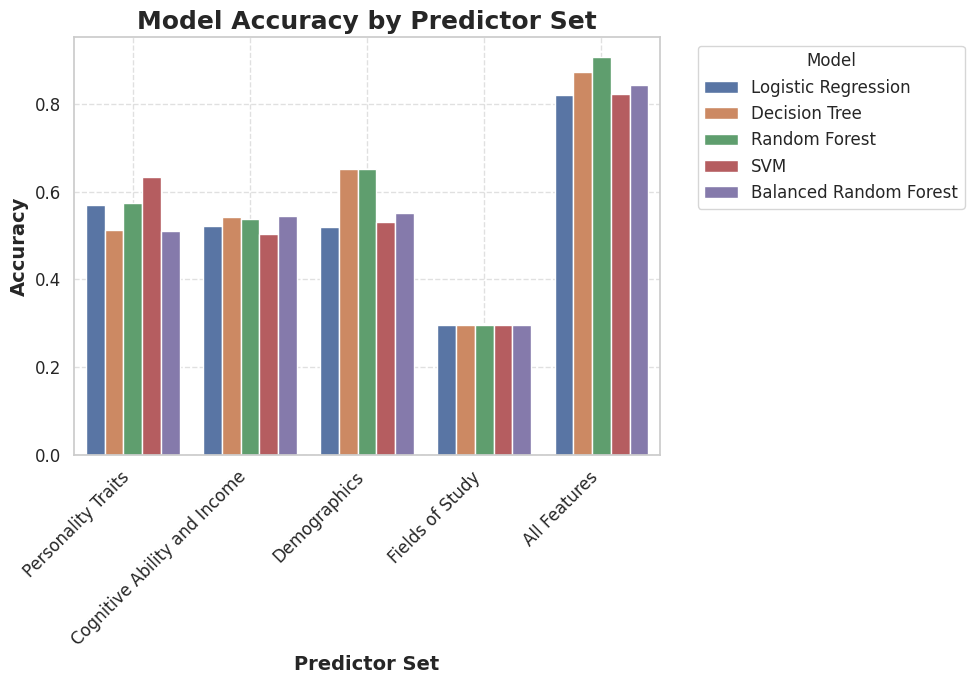

In [19]:
# Set the style and color palette
sns.set(style="whitegrid")  # Clean background
palette = sns.color_palette("deep")  # Professional color palette

# Create the accuracy plot
plt.figure(figsize=(10, 7))
sns.barplot(data=results_df, x='Predictor Set', y='Accuracy', hue='Model', palette=palette, ci=None, edgecolor='w')

# Add plot title and labels
plt.title('Model Accuracy by Predictor Set', fontsize=18, weight='bold')
plt.xlabel('Predictor Set', fontsize=14, weight='bold')
plt.ylabel('Accuracy', fontsize=14, weight='bold')

# Customize tick labels
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.6)

# Add legend
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


The accuracy results highlight that using the "All Features" set consistently yields the highest performance across models, notably achieving the best results with the Random Forest model. This comprehensive set provides the broadest range of information, enhancing the models' predictive capabilities. In contrast, the "Fields of Study" set underperforms across all models, likely due to its narrower focus and potentially less informative features. Sets like "Demographics" and "Personality Traits" show variable results, with some models performing well, indicating these feature sets have their strengths but might not be as universally effective as the more extensive "All Features" set. Fields of study still might suffer from the unbalanced x_choice distribution and is probably biased and predicts the same value across all models and observations.

#### b)
Try to fill the gaps in the data using appropriate prediction models.

In [20]:
# Check for missing values
missing_summary = merged_data.isnull().sum()
print(missing_summary[missing_summary > 0])

bf_consciousness     546
bf_openness          546
bf_extraversion      546
bf_agreeableness     546
bf_neuroticism       546
cogabil              546
pe_D1_stud_natsci    546
pe_D1_stud_law       546
pe_D1_stud_socsci    546
pe_D1_stud_med       546
pe_monthinc          546
pe_age               546
pe_female            546
dtype: int64


### Filling Missing Values

To handle missing values in our dataset, we utilized machine learning models suited to the type of data:

- **Numerical Data:** We employed the `RandomForestRegressor` to predict and fill missing values in numerical columns. This model was chosen for its ability to capture complex, non-linear relationships between features, providing accurate imputations.

- **Categorical Data:** For categorical columns, we used the `RandomForestClassifier` to predict and impute missing values. This model effectively handles categorical complexity and classifies missing entries based on the relationships between features.

This approach enhances the completeness and usability of the dataset, ensuring it is ready for further analysis or modeling and improving overall data quality.


In [21]:
# Identify numerical and categorical columns
numerical_columns = ['bf_consciousness', 'bf_openness', 'bf_extraversion', 'bf_agreeableness',
                      'bf_neuroticism', 'cogabil', 'pe_monthinc', 'pe_age']

categorical_columns = ['pe_female', 'pe_D1_stud_natsci', 'pe_D1_stud_law',
                       'pe_D1_stud_socsci', 'pe_D1_stud_med', 'choice_x']

# Function to fill missing numerical values
def fill_missing_values_numeric(df, target_col, predictors):
    df_filled = df.copy()
    df_missing = df_filled[df_filled[target_col].isnull()]
    df_not_missing = df_filled.dropna(subset=[target_col])

    if df_missing.shape[0] == 0:
        return df_filled

    X_train = df_not_missing[predictors]
    y_train = df_not_missing[target_col]
    X_missing = df_missing[predictors]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    df_filled.loc[df_filled[target_col].isnull(), target_col] = model.predict(X_missing)
    return df_filled

# Function to fill missing categorical values
def fill_missing_values_categorical(df, target_col, predictors):
    df_filled = df.copy()
    df_missing = df_filled[df_filled[target_col].isnull()]
    df_not_missing = df_filled.dropna(subset=[target_col])

    if df_missing.shape[0] == 0:
        return df_filled

    X_train = df_not_missing[predictors]
    y_train = df_not_missing[target_col]
    X_missing = df_missing[predictors]

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    df_filled.loc[df_filled[target_col].isnull(), target_col] = model.predict(X_missing)
    return df_filled

Now fill the missing vales and check it

In [22]:
# Filling missing values in numerical columns
for col in numerical_columns:
    if merged_data_cleaned[col].isnull().sum() > 0:
        print(f"Filling missing values for numerical column: {col}")
        predictors = [c for c in numerical_columns if c != col]
        merged_data_cleaned = fill_missing_values_numeric(merged_data_cleaned, col, predictors)

# Filling missing values in categorical columns
for col in categorical_columns:
    if merged_data_cleaned[col].isnull().sum() > 0:
        print(f"Filling missing values for categorical column: {col}")
        predictors = [c for c in categorical_columns if c != col]
        merged_data_cleaned = fill_missing_values_categorical(merged_data_cleaned, col, predictors)

# Verify that there are no missing values left
print("Missing values after imputation:")
print(merged_data_cleaned.isnull().sum())

Missing values after imputation:
sid                  0
gid                  0
order                0
self_x               0
self_y               0
other_x              0
other_y              0
choice_x             0
s_y                  0
s_x                  0
r_y                  0
r_x                  0
bf_consciousness     0
bf_openness          0
bf_extraversion      0
bf_agreeableness     0
bf_neuroticism       0
cogabil              0
pe_D1_stud_natsci    0
pe_D1_stud_law       0
pe_D1_stud_socsci    0
pe_D1_stud_med       0
pe_monthinc          0
pe_age               0
pe_female            0
dtype: int64


#### c)
The questionnaire by Bruhin et al. comprises personality traits according to the Big Five. <br>
This question asks you to impute other (economic) preferences of the study participants. <br>
Examples include:
- Social preferences (inequity aversion, reciprocity, guilt aversion...)
- Time preferences (myopia, present bias...)
- Risk preferences
- ...

Your taks is thus the following:
1. Find a dataset on individuals that contains the Big Five along with other preference measures. Think of datasets used in scientific publications.
2. Train models to predict the other preferences from the Big Five. Evaluate their performance.
3. Make an out-of sample prediction using the fitted models to impute the preference measures for the study participants of Bruhin et al.

## Data Source

The data used for the preference measures is sourced from the Panel Study of Income Dynamics (PSID), a longitudinal household survey conducted by the University of Michigan. The PSID provides extensive data on various aspects of American life, including economic, social, and health factors. For more information, visit the [PSID website](https://psidonline.isr.umich.edu/).
The Codebook for the choosen Data will also be uploaded.


## Dataset Description

The dataset includes the following variables:

### Big Five Personality Traits:
- **Conscientiousness**: Variable `TA212333`
- **Agreeableness**: Variable `TA212334`
- **Neuroticism**: Variable `TA212335`
- **Extraversion**: Variable `TA212336`
- **Openness**: Variable `TA212337`

### Social Preferences:
- **Languishing/Flourishing**: Variable `TA212316`
- **Social Anxiety**: Variable `TA212318`
- **Rosenberg Self-Esteem**: Variable `TA212319`
- **Everyday Discrimination**: Variable `TA212323`
- **Loneliness**: Variable `TA212346`

### (Economic) Preferences:
- **Risky Behaviors**: Variable `TA212324`
- **Sensation Seeking**: Variable `TA212325`
- **Financial Responsibility**: Variable `TA212328`

These variables encompass a range of behavioral and psychological measures that can impact economic preferences. They provide valuable insights into how personality traits and individual experiences influence economic decision-making, risk tolerance, financial behavior, and social interactions.

--> For more details about the varibles have a look at the provided codebook.


**Task Solution**

1. Load and preprocess the data.
2. Define features, targets, and split the data.
3. Define evaluation and hyperparameter tuning functions.
4. Train and evaluate models.
5. Predict and combine with Bruhin et al. data.

**1. Load and Preprocess the Preference Data**

This part involves loading the dataset, selecting relevant columns, renaming them for clarity, replacing specific missing value codes with NaN, and standardizing the Big Five personality traits

In [23]:
# Preprocess the data

def preprocess_data(data):
    # Define the columns you will use
    columns = [
        'TA212316', 'TA212318', 'TA212319', 'TA212323', 'TA212324', 'TA212325',
        'TA212328', 'TA212333', 'TA212334', 'TA212335', 'TA212336', 'TA212337',
        'TA212346'
    ]

    # Select relevant columns
    data = data[columns]

    # Rename columns to label name for clarity
    data.columns = [
        'languishing_flourishing', 'social_anxiety', 'self_esteem',
        'everyday_discrimination', 'risky_behaviors', 'sensation_seeking',
        'financial_responsibility', 'conscientiousness', 'agreeableness',
        'neuroticism', 'extraversion', 'openness', 'loneliness'
    ]

    # Replace specific missing value codes with NaN
    big_five_traits = ['conscientiousness', 'agreeableness', 'neuroticism', 'extraversion', 'openness']
    other_traits = ['languishing_flourishing', 'social_anxiety', 'self_esteem', 'everyday_discrimination', 'risky_behaviors', 'sensation_seeking', 'financial_responsibility', 'loneliness']

    # Replace 97 and 99 with NaN for Big Five traits  /fill values for no values in the PSID Panel
    data[big_five_traits] = data[big_five_traits].replace([97, 99], pd.NA)

    # Replace 9 with NaN for other traits             /fill values for no values in the PSID Panel
    data[other_traits] = data[other_traits].replace(9, pd.NA)

    # Drop rows with any NaN values
    data = data.dropna()

    # Standardize Big Five personality traits
    scaler = MinMaxScaler(feature_range=(0, 21))
    data[big_five_traits] = scaler.fit_transform(data[big_five_traits])

    return data

# Preprocess the already loaded preference_data
preference_data_processed = preprocess_data(preference_data)

# Display the first few rows of the processed preference_data to ensure it's processed correctly
display(preference_data_processed.head())


<ipython-input-23-aed9503175a1>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[big_five_traits] = data[big_five_traits].replace([97, 99], pd.NA)
<ipython-input-23-aed9503175a1>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[other_traits] = data[other_traits].replace(9, pd.NA)
<ipython-input-23-aed9503175a1>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

,languishing_flourishing,social_anxiety,self_esteem,everyday_discrimination,risky_behaviors,sensation_seeking,financial_responsibility,conscientiousness,agreeableness,neuroticism,extraversion,openness,loneliness
1,16,3,25,1,1,1,3,14.368421,14.4375,9.333333,12.833333,13.125,3
8,15,4,15,5,1,1,4,16.578947,18.3750,15.166667,12.833333,15.750,6
10,17,4,22,3,1,1,0,18.789474,11.8125,11.666667,15.166667,5.250,3
12,11,4,19,4,1,1,5,12.157895,13.1250,14.000000,11.666667,10.500,7
16,16,3,27,3,1,2,0,16.578947,15.7500,5.833333,15.166667,12.250,3


In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Preprocess the data
def preprocess_data(data):
    # Define the columns you will use
    columns = [
        'TA212316', 'TA212318', 'TA212319', 'TA212323', 'TA212324', 'TA212325',
        'TA212328', 'TA212333', 'TA212334', 'TA212335', 'TA212336', 'TA212337',
        'TA212346'
    ]

    # Select relevant columns
    data = data[columns]

    # Rename columns to label name for clarity
    data.columns = [
        'languishing_flourishing', 'social_anxiety', 'self_esteem',
        'everyday_discrimination', 'risky_behaviors', 'sensation_seeking',
        'financial_responsibility', 'conscientiousness', 'agreeableness',
        'neuroticism', 'extraversion', 'openness', 'loneliness'
    ]

    # Replace specific missing value codes with np.nan
    big_five_traits = ['conscientiousness', 'agreeableness', 'neuroticism', 'extraversion', 'openness']
    other_traits = ['languishing_flourishing', 'social_anxiety', 'self_esteem', 'everyday_discrimination', 'risky_behaviors', 'sensation_seeking', 'financial_responsibility', 'loneliness']

    # Replace 97 and 99 with np.nan for Big Five traits
    data.loc[:, big_five_traits] = data.loc[:, big_five_traits].replace([97, 99], np.nan)

    # Replace 9 with np.nan for other traits
    data.loc[:, other_traits] = data.loc[:, other_traits].replace(9, np.nan)

    # Impute missing values using Iterative Imputer
    imputer = IterativeImputer(max_iter=10, random_state=42)
    data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

    # Standardize Big Five personality traits
    scaler = MinMaxScaler(feature_range=(0, 21))
    data_imputed[big_five_traits] = scaler.fit_transform(data_imputed[big_five_traits])

    return data_imputed

# Preprocess the already loaded preference_data
preference_data_processed = preprocess_data(preference_data)

# Display the first few rows of the processed preference_data to ensure it's processed correctly
preference_data_processed.head()


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,languishing_flourishing,social_anxiety,self_esteem,everyday_discrimination,risky_behaviors,sensation_seeking,financial_responsibility,conscientiousness,agreeableness,neuroticism,extraversion,openness,loneliness
0,14.0,3.0,97.0,1.0,1.0,1.0,0.0,17.729939,14.304405,7.898619,14.948494,17.143696,3.0
1,16.0,3.0,25.0,1.0,1.0,1.0,3.0,14.368421,14.437500,10.470268,11.767248,13.125000,3.0
2,13.0,4.0,97.0,3.0,1.0,2.0,0.0,17.005785,13.363137,10.336877,13.182318,16.798660,6.0
3,15.0,5.0,97.0,5.0,1.0,1.0,0.0,16.379999,12.637312,13.277918,11.430163,16.640790,5.0
4,12.0,3.0,97.0,2.0,1.0,1.0,0.0,17.613829,13.953423,8.282894,14.836260,17.273762,4.0


**2. Define Features, Targets, and Split Data**

This part involves defining the features and targets, and splitting the data into training and testing sets.

In [25]:
# Define features and targets from preference_data
features = ['conscientiousness', 'agreeableness', 'neuroticism', 'extraversion', 'openness']
targets = ['languishing_flourishing', 'social_anxiety', 'self_esteem', 'everyday_discrimination', 'risky_behaviors', 'sensation_seeking', 'financial_responsibility']

X = preference_data_processed[features]
y = preference_data_processed[targets]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize MinMaxScaler for scaling features between 0 and 21
feature_scaler = MinMaxScaler(feature_range=(0, 21))
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)


**3. Define Evaluation and Hyperparameter Tuning Functions**

In [26]:
# Define model evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'R2': r2_score(y_test, y_pred, multioutput='uniform_average'),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    }

# Hyperparameter tuning
def hyperparameter_tuning(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_


**4. Train and Evaluate Models**

This part trains and evaluates different models, and selects the best model based on the R-squared value.

In [27]:

# Models and their parameters for hyperparameter tuning
models = {
    'Linear Regression': (LinearRegression(), {}),
    'Random Forest': (MultiOutputRegressor(RandomForestRegressor()), {
        'estimator__n_estimators': [100, 200],
        'estimator__max_depth': [None, 10, 20]
    }),
    'Support Vector Machine': (MultiOutputRegressor(SVR()), {
        'estimator__C': [0.1, 1, 10],
        'estimator__gamma': [0.01, 0.1, 1]
    }),
    'Gradient Boosting': (MultiOutputRegressor(GradientBoostingRegressor()), {
        'estimator__n_estimators': [100, 200],
        'estimator__learning_rate': [0.01, 0.1, 0.2]
    }),
    'K-Nearest Neighbors': (MultiOutputRegressor(KNeighborsRegressor()), {
        'estimator__n_neighbors': [3, 5, 7]
    })
}

# Train and evaluate models
model_results = {}
for model_name, (model, param_grid) in models.items():
    if param_grid:
        best_model = hyperparameter_tuning(model, param_grid, X_train_scaled, y_train)
    else:
        best_model = model
    model_results[model_name] = evaluate_model(best_model, X_train_scaled, y_train, X_test_scaled, y_test)

# Select best model
best_model_name = max(model_results, key=lambda k: model_results[k]['R2'])
best_model = models[best_model_name][0]
if models[best_model_name][1]:
    best_model = hyperparameter_tuning(best_model, models[best_model_name][1], X_train_scaled, y_train)

print(f"Best model: {best_model_name}")
print(model_results[best_model_name])


Best model: Random Forest
{'R2': 0.5605210403563525, 'MAE': 1.212233363375971, 'RMSE': 5.071551360101324}


**5. Predict and Combine with Bruhin et al. Data**

This part predicts the economic preferences for Bruhin et al. participants using the best model and combines the predictions with the original data.

In [28]:
# Rename columns in merged_data_cleaned to match those in preference_data
bruhin_data = merged_data_cleaned.rename(columns={
    'bf_consciousness': 'conscientiousness',
    'bf_openness': 'openness',
    'bf_extraversion': 'extraversion',
    'bf_agreeableness': 'agreeableness',
    'bf_neuroticism': 'neuroticism'
})

features = ['conscientiousness', 'agreeableness', 'neuroticism', 'extraversion', 'openness']

# Ensure the features are aligned with what the model expects
bruhin_data = bruhin_data[features]

# Scale the features
bruhin_data_scaled = feature_scaler.transform(bruhin_data)

# Predict economic preferences for Bruhin et al. participants
imputed_preferences = best_model.predict(bruhin_data_scaled)

# Combine predictions with Bruhin et al. data
bruhin_data_with_preferences = merged_data_cleaned.copy()
bruhin_data_with_preferences[targets] = imputed_preferences

# Round numerical values to two decimal places
bruhin_data_with_preferences = bruhin_data_with_preferences.round(2)

display(bruhin_data_with_preferences.head())


,sid,gid,order,self_x,self_y,other_x,other_y,choice_x,s_y,s_x,...,pe_monthinc,pe_age,pe_female,languishing_flourishing,social_anxiety,self_esteem,everyday_discrimination,risky_behaviors,sensation_seeking,financial_responsibility
39,112010050603,11,1,450,210,1020,720,1,1,1,...,2200.0,21.0,0.0,18.44,2.62,30.51,3.35,1.84,2.32,3.54
40,112010050603,61,2,410,250,1050,690,1,1,1,...,2200.0,21.0,0.0,18.44,2.62,30.51,3.35,1.84,2.32,3.54
41,112010050603,391,3,1060,680,330,330,1,0,0,...,2200.0,21.0,0.0,18.44,2.62,30.51,3.35,1.84,2.32,3.54
42,112010050603,111,4,470,190,730,1010,1,1,1,...,2200.0,21.0,0.0,18.44,2.62,30.51,3.35,1.84,2.32,3.54
43,112010050603,21,5,430,230,1030,710,1,1,1,...,2200.0,21.0,0.0,18.44,2.62,30.51,3.35,1.84,2.32,3.54


**Overview of the imputed Values**

In [31]:
pd.set_option('display.max_columns', None)

print("bruhin_data_with_preferences")
display(bruhin_data_with_preferences.head(3))

print("merged_data_cleaned")
display(merged_data_cleaned.head(3))

bruhin_data_with_preferences


,sid,gid,order,self_x,self_y,other_x,other_y,choice_x,s_y,s_x,r_y,r_x,bf_consciousness,bf_openness,bf_extraversion,bf_agreeableness,bf_neuroticism,cogabil,pe_D1_stud_natsci,pe_D1_stud_law,pe_D1_stud_socsci,pe_D1_stud_med,pe_monthinc,pe_age,pe_female,languishing_flourishing,social_anxiety,self_esteem,everyday_discrimination,risky_behaviors,sensation_seeking,financial_responsibility
39,112010050603,11,1,450,210,1020,720,1,1,1,0,0,10.0,22.0,9.0,4.0,1.0,3.0,0.0,0.0,1.0,0.0,2200.0,21.0,0.0,18.44,2.62,30.51,3.35,1.84,2.32,3.54
40,112010050603,61,2,410,250,1050,690,1,1,1,0,0,10.0,22.0,9.0,4.0,1.0,3.0,0.0,0.0,1.0,0.0,2200.0,21.0,0.0,18.44,2.62,30.51,3.35,1.84,2.32,3.54
41,112010050603,391,3,1060,680,330,330,1,0,0,1,1,10.0,22.0,9.0,4.0,1.0,3.0,0.0,0.0,1.0,0.0,2200.0,21.0,0.0,18.44,2.62,30.51,3.35,1.84,2.32,3.54


merged_data_cleaned


,sid,gid,order,self_x,self_y,other_x,other_y,choice_x,s_y,s_x,r_y,r_x,bf_consciousness,bf_openness,bf_extraversion,bf_agreeableness,bf_neuroticism,cogabil,pe_D1_stud_natsci,pe_D1_stud_law,pe_D1_stud_socsci,pe_D1_stud_med,pe_monthinc,pe_age,pe_female
39,112010050603,11,1,450,210,1020,720,1,1,1,0,0,10.0,22.0,9.0,4.0,1.0,3.0,0.0,0.0,1.0,0.0,2200.0,21.0,0.0
40,112010050603,61,2,410,250,1050,690,1,1,1,0,0,10.0,22.0,9.0,4.0,1.0,3.0,0.0,0.0,1.0,0.0,2200.0,21.0,0.0
41,112010050603,391,3,1060,680,330,330,1,0,0,1,1,10.0,22.0,9.0,4.0,1.0,3.0,0.0,0.0,1.0,0.0,2200.0,21.0,0.0


# Problem 4 - Unsupervised Machine Learning
Use subjects' behaviors and information from the questionnaire to cluster individuals. <br>
Which is the optimal number of clusters? <br>
Can you provide an intuition for the clusters you identified? <br>
Do the clusters change when you include the imputed preferences from Problem 3c)?

In [32]:
questionnaire_data = merged_data_cleaned
bruhin_data_with_preferences = bruhin_data_with_preferences

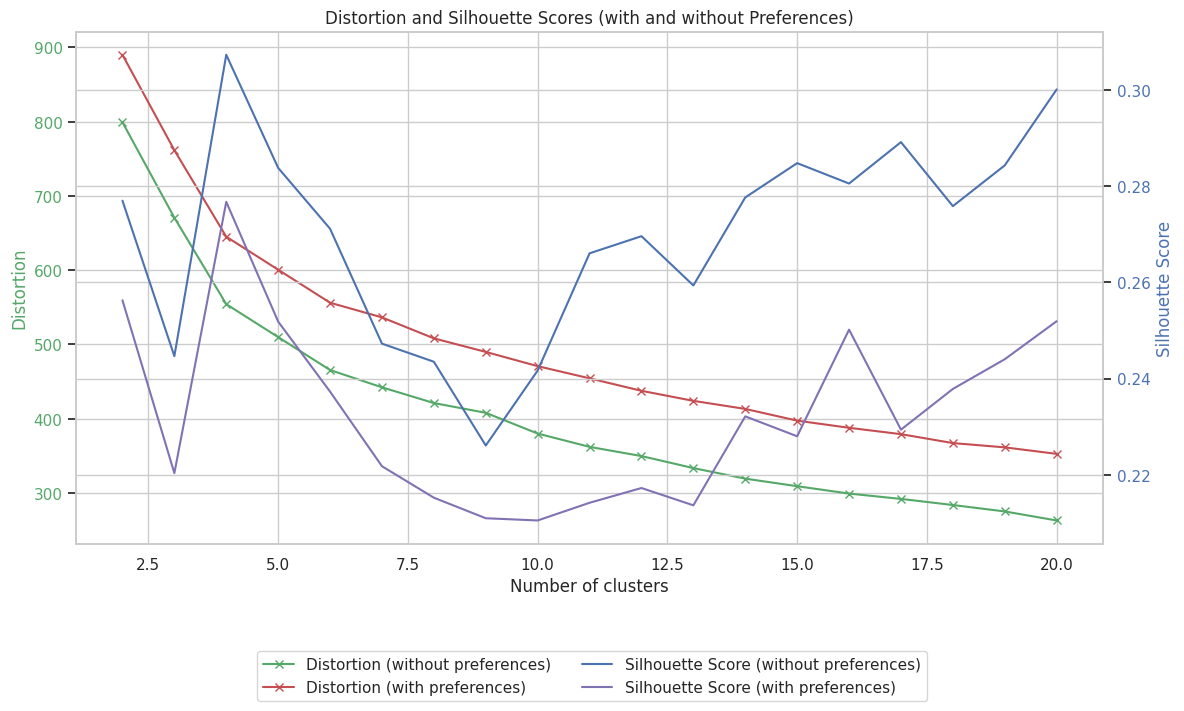

In [33]:

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def calculate_distortion_and_silhouette(X, max_clusters=20):
    distortions = []
    silhouette_scores = []

    for n_clusters in range(2, max_clusters + 1):  # Start from 2 clusters
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_ / len(X))  # Normalize by the number of data points
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))

    return distortions, silhouette_scores

def plot_combined_metrics(distortions1, silhouette_scores1, distortions2, silhouette_scores2, title):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot for first dataset
    ax1.plot(range(2, len(distortions1) + 2), distortions1, 'gx-', label='Distortion (without preferences)')
    ax1.plot(range(2, len(distortions2) + 2), distortions2, 'rx-', label='Distortion (with preferences)')
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('Distortion', color='g')
    ax1.tick_params(axis='y', labelcolor='g')

    ax2 = ax1.twinx()
    ax2.plot(range(2, len(silhouette_scores1) + 2), silhouette_scores1, 'b-', label='Silhouette Score (without preferences)')
    ax2.plot(range(2, len(silhouette_scores2) + 2), silhouette_scores2, 'm-', label='Silhouette Score (with preferences)')
    ax2.set_ylabel('Silhouette Score', color='b')
    ax2.tick_params(axis='y', labelcolor='b')

    fig.tight_layout()
    plt.title(title)

    # Create a single legend outside of the plot
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    fig.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2)

    plt.show()

def preprocess_and_cluster(data, features):
    # Assume all features are numeric since categorical variables are already encoded
    numeric_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler(feature_range=(0, 21)))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, features)
        ])

    # Preprocess the data
    X_preprocessed = preprocessor.fit_transform(data[features].dropna())
    return X_preprocessed

# Define the features for clustering without preferences
features_without_preferences = [
    'bf_consciousness', 'bf_openness', 'bf_extraversion',
    'bf_agreeableness', 'bf_neuroticism', 'cogabil',
    'pe_D1_stud_natsci', 'pe_D1_stud_law', 'pe_D1_stud_socsci',
    'pe_D1_stud_med', 'pe_monthinc', 'pe_age', 'pe_female',
    'self_x', 'self_y', 'other_x', 'other_y', 'choice_x', 's_y', 's_x', 'r_y', 'r_x'
]

# Define the features for clustering with preferences
features_with_preferences = features_without_preferences + [
    'languishing_flourishing', 'social_anxiety', 'self_esteem',
    'everyday_discrimination', 'risky_behaviors', 'sensation_seeking',
    'financial_responsibility'
]

# Process and cluster questionnaire data without preferences
X_without_preferences = preprocess_and_cluster(questionnaire_data, features_without_preferences)
distortions_without, silhouette_scores_without = calculate_distortion_and_silhouette(X_without_preferences)

# Process and cluster bruhin data with preferences
X_with_preferences = preprocess_and_cluster(bruhin_data_with_preferences, features_with_preferences)
distortions_with, silhouette_scores_with = calculate_distortion_and_silhouette(X_with_preferences)

# Plot combined metrics
plot_combined_metrics(distortions_without, silhouette_scores_without, distortions_with, silhouette_scores_with, 'Distortion and Silhouette Scores (with and without Preferences)')


#### Optimal Number of Clusters

Analyzing both the distortion and silhouette score plots, we determine that around 5 clusters are optimal for both datasets. The elbow method suggests this number as the point where the decrease in distortion levels off, while silhouette scores indicate that 2 to 3 clusters capture the data's structure best. Combining these insights, 5 clusters strike a balance between reduced distortion and reasonable silhouette scores.

#### Intuition for Clusters

Clusters formed without preferences are based on personality traits and demographics, grouping individuals with similar profiles and backgrounds. Including preferences, such as economic and social behaviors, results in more nuanced clusters that reflect a richer understanding of individual differences.

#### Changes with Imputed Preferences

Including imputed preferences adds complexity to the clustering process. Distortion values are higher, indicating increased variance within clusters due to the additional dimensions. Silhouette scores are slightly lower but stable, suggesting that preferences add valuable clustering information. The inclusion of preferences changes cluster composition, highlighting variations in economic and social behaviors not captured by personality traits alone.

In summary, 5 clusters are optimal for both datasets. Clustering without preferences reflects personality traits and demographics, while clustering with preferences captures a broader range of behaviors and characteristics, enhancing the richness and detail of the clustering.
